In [1]:
import dill
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.express as px
import plotly.graph_objs as go
print('done')
import csv
import matplotlib

results_folder_string = "results_merged"
# USE_PLOTLY = False




done


In [2]:
def load_from_csv(input_string):
    with open(input_string, 'r') as fp:
        reader = csv.reader(fp)
        li = list(reader)
    newlist = []
    for row in li:
        newrow = []
        for entry in row [1:]:
            if entry!='':
                newrow.append(float(entry))
        newlist.append(newrow)
    return newlist


experiment_config_JSD_before = load_from_csv(results_folder_string+"/experiment_config_JSD_before.csv")
experiment_config_JSD_after = load_from_csv(results_folder_string+"/experiment_config_JSD_after.csv")
experiment_config_flip_TP = load_from_csv(results_folder_string+"/experiment_config_flip_TP.csv")
experiment_config_flip_TN = load_from_csv(results_folder_string+"/experiment_config_flip_TN.csv")
experiment_config_flip_FP = load_from_csv(results_folder_string+"/experiment_config_flip_FP.csv")
experiment_config_flip_FN = load_from_csv(results_folder_string+"/experiment_config_flip_FN.csv")
experiment_config_entropy_before = load_from_csv(results_folder_string+"//experiment_config_entropy_before.csv")
experiment_config_entropy_after = load_from_csv(results_folder_string+"/experiment_config_entropy_after.csv")

with open("experiments","rb") as current_file:
    experiments = dill.load(current_file)

    
non_unique_params = np.array([experiment['parameter'] for experiment in experiments])
non_unique_config_strings = np.array([experiment['config_string'] for experiment in experiments],dtype=object)

par_indices = np.unique(non_unique_params,return_index=True)[1]
string_indices = np.unique(non_unique_config_strings,return_index=True)[1]

parameters = non_unique_params[np.sort(par_indices)]
config_strings = non_unique_config_strings[np.sort(string_indices)]
# config_strings[0],config_strings[1],config_strings[2] = config_strings[2],config_strings[0],config_strings[1]
# config_strings[[0,1,2]] = config_strings[[2,0,1]]
print(config_strings)


def str_noneguard(obj):
    if hasattr(obj,'__name__'):
        return obj.__name__
    if obj is None:
        return ''
    if isinstance(obj,list):
        return str([str_noneguard(x) for x in obj])
    return str(obj)


print(len(config_strings))
# colors=['#4285F4','#EA4335', '#FBBC04',  '#34A853','#000000','#46BDC6',      '#46BDC6',             '#F4CCCC','#C9DAF8',            'grey','purple']
# red yellow !!!! !!!!! green teal ?? !!!!!!
# colors=['#EA4335', '#FBBC04', '#4285F4', '#000000','#34A853','#46BDC6',                  '#F4CCCC','purple',]
#        red         yellow      teal       black     green     blue      ??     purple
colors=['#EA4335', '#FBBC04', '#46BDC6', '#000000','#34A853','#4285F4', 'None',  'purple']
#         teal        red       black     yellow    purple     green       blue       ??
colors=['#46BDC6', '#EA4335', '#000000', '#FBBC04','#800080','#34A853', '#4285F4',  '#EEEEEE']
print(len(colors))
print(config_strings)
print("")
print("")

print(parameters)
print("")

# parameters[[3,4,5,6,7,8,9,10,11,12]] = parameters[[-4,-3,-2,5,3,4,6,8,-1,7]]
print(parameters)

# CCE_strings = [config_string for config_string in config_strings if "CCE" in config_string]
CCE_strings = [config_string for config_string in config_strings if "JSD" in config_string]



['JSDu, surgical_case_durations NO_ADDED_NOISE'
 'JSDu, LBP RA NO_ADDED_NOISE'
 'JSDu, surgical_case_durations NO_ADDED_NOISE SD=4'
 'JSDu, LBP RA NO_ADDED_NOISE SD=4'
 'JSDu, surgical_case_durations NO_ADDED_NOISE SD=100'
 'JSDu, LBP RA NO_ADDED_NOISE SD=100' 'JSD, surgical_case_durations'
 'JSDu, surgical_case_durations' 'JSD, LBP RA' 'JSDu, LBP RA'
 'JSD, surgical_case_durations, SD=4'
 'JSDu, surgical_case_durations, SD=4' 'JSD, LBP RA, SD=4'
 'JSDu, LBP RA, SD=4' 'JSD, surgical_case_durations, SD=100'
 'JSDu, surgical_case_durations, SD=100' 'JSD, LBP RA, SD=100'
 'JSDu, LBP RA, SD=100' 'CCE, SD=4' 'JSD, SD=4' 'CCEu, SD=4' 'JSDu, SD=4'
 'CCE, SD=100' 'JSD, SD=100' 'JSDu, SD=100']
25
8
['JSDu, surgical_case_durations NO_ADDED_NOISE'
 'JSDu, LBP RA NO_ADDED_NOISE'
 'JSDu, surgical_case_durations NO_ADDED_NOISE SD=4'
 'JSDu, LBP RA NO_ADDED_NOISE SD=4'
 'JSDu, surgical_case_durations NO_ADDED_NOISE SD=100'
 'JSDu, LBP RA NO_ADDED_NOISE SD=100' 'JSD, surgical_case_durations'
 'JSDu, s

In [3]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from textwrap import wrap
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

def hex_to_rgb(hex_color: str) -> tuple:
    # thanks to https://community.plotly.com/t/scatter-plot-fill-with-color-how-to-set-opacity-of-fill/29591/2
    hex_color = hex_color.lstrip("#")
    if len(hex_color) == 3:
        hex_color = hex_color * 2
    return int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)

def adjust_lightness(color, amount=0.5):
    # All credits for this function go to Ian Hincks and F Lekschas
    # https://stackoverflow.com/a/49601444
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])    

def plot_vals(i,USE_PLOTLY,excluded_config_strings=[],ylim=[-175,100]):

    if USE_PLOTLY:
        fig = go.Figure()

    else:
        fig, ax = plt.subplots(figsize=[10,6])  
        

    parameter = parameters[i]
    bar=0
    all_numbers = True
    
    for config_index,config_string in enumerate(config_strings):
        if "NO_ADDED_NOISE" in config_string or "surgical_case_durations" in config_string or "LBP RA" in config_string:
            continue
        color=colors[config_index-18]
    #     print("--------- " + config_string + " -----------")
        filtered_experiments = [ex for ex in experiments if ex['parameter']==parameter and ex['config_string']==config_string and config_string not in excluded_config_strings]
        if len(filtered_experiments)==0:
            continue
        mappings = np.array([x['mapping'] for x in filtered_experiments])
        x_values = [x['current_var'] for x in filtered_experiments]
        for x in x_values:
            if not isinstance(x,int) and not isinstance(x,float):
                all_numbers=False

        if not all_numbers:
            for i in range(len(x_values)):
                x_values[i] = str_noneguard(x_values[i])

        JSD_before = np.array([np.array(result) for result in np.array(experiment_config_JSD_before,dtype=object)[mappings] ])
        JSD_after = np.array([np.array(result) for result in np.array(experiment_config_JSD_after,dtype=object)[mappings] ])
        flip_TP = np.array([np.array(result) for result in np.array(experiment_config_flip_TP,dtype=object)[mappings] ])
        flip_TN = np.array([np.array(result) for result in np.array(experiment_config_flip_TN,dtype=object)[mappings] ])
        flip_FP = np.array([np.array(result) for result in np.array(experiment_config_flip_FP,dtype=object)[mappings] ])
        flip_FN = np.array([np.array(result) for result in np.array(experiment_config_flip_FN,dtype=object)[mappings] ])
        entropy_before = np.array([np.array(result) for result in np.array(experiment_config_entropy_before,dtype=object)[mappings] ])
        entropy_after = np.array([np.array(result) for result in np.array(experiment_config_entropy_after,dtype=object)[mappings] ])

        if np.issubdtype(JSD_before.dtype,np.number):
            JSD_reduction = 100 - ((JSD_after / JSD_before)*100)
            accuracy =100 * ((flip_TP+flip_TN) / (flip_TP+flip_TN+flip_FP+flip_FN))
            f1_score = 100 * ((flip_TP) / (flip_TP + 0.5*(flip_FP + flip_FN)))
            entropy_reduction = 100 - ((entropy_after / entropy_before)*100)

            means_JSD_reduction = np.mean(JSD_reduction,axis=1)
            sigmas_JSD_reduction = np.std(JSD_reduction,axis=1)
            means_accuracy = np.mean(accuracy,axis=1)
            sigmas_accuracy = np.std(accuracy,axis=1)
            means_f1_score = np.mean(f1_score,axis=1)
            sigmas_f1_score = np.std(f1_score,axis=1)
            means_entropy_reduction = np.mean(entropy_reduction,axis=1)
            sigmas_entropy_reduction = np.std(entropy_reduction,axis=1)
        else:
            JSD_reduction = []
            accuracy = []
            f1_score = []
            entropy_reduction = []
            means_JSD_reduction = []
            sigmas_JSD_reduction = []
            means_accuracy = []
            sigmas_accuracy = []
            means_f1_score = []
            sigmas_f1_score = []
            means_entropy_reduction = []
            sigmas_entropy_reduction = []
            for i in range(len(JSD_before)):
                JSD_reduction_current = 100 - ((JSD_after[i] / JSD_before[i])*100)
                accuracy_current =100 * ((flip_TP[i]+flip_TN[i]) / (flip_TP[i]+flip_TN[i]+flip_FP[i]+flip_FN[i]))
                f1_score_current = 100 * ((flip_TP[i]) / (flip_TP[i] + 0.5*(flip_FP[i] + flip_FN[i])))
                entropy_reduction_current = 100 - ((entropy_after[i] / entropy_before[i])*100)
                
                JSD_reduction.append(JSD_reduction_current)
                accuracy.append(accuracy_current)
                f1_score.append(f1_score_current)
                entropy_reduction.append(entropy_reduction_current)

                means_JSD_reduction.append(np.mean(JSD_reduction_current))
                sigmas_JSD_reduction.append(np.std(JSD_reduction_current))
                means_accuracy.append(np.mean(accuracy_current))
                sigmas_accuracy.append(np.std(accuracy_current))
                means_f1_score.append(np.mean(f1_score_current))
                sigmas_f1_score.append(np.std(f1_score_current))
                means_entropy_reduction.append(np.mean(entropy_reduction_current))
                sigmas_entropy_reduction.append(np.std(entropy_reduction_current))
                
            JSD_reduction = np.array(JSD_reduction)
            accuracy = np.array(accuracy)
            f1_score = np.array(f1_score)
            entropy_reduction = np.array(entropy_reduction)
            means_JSD_reduction = np.array(means_JSD_reduction)
            sigmas_JSD_reduction = np.array(sigmas_JSD_reduction)
            means_accuracy = np.array(means_accuracy)
            sigmas_accuracy = np.array(sigmas_accuracy)
            means_f1_score = np.array(means_f1_score)
            sigmas_f1_score = np.array(sigmas_f1_score)
            means_entropy_reduction = np.array(means_entropy_reduction)
            sigmas_entropy_reduction = np.array(sigmas_entropy_reduction)


        # TODO use other values as well

        # means = means_JSD_reduction
        # sigmas = sigmas_JSD_reduction

        config_string=config_string.replace('SD=4', 'categorical')
        config_string=config_string.replace('SD=100', 'continuous')
        config_string=config_string.replace('CCE', 'Log loss')
        config_string=config_string.replace('JSD', 'JSD loss')
        config_string=config_string.replace('loss,', 'loss (semi-supervised),')
        config_string=config_string.replace('u,', ' (unsupervised),')

        if parameter=="training_method":
            config_string=config_string.replace(' (semi-supervised),', ',')
        if parameter=="sampling_density":
            config_string=config_string.replace(', categorical', '')

        

        parameter_string = parameter.replace('_',' ').capitalize()

        #x_values

        #['training_method' 'labeled_data_percentage' 'sampling_density'
 #'activation_types' 'input_layer_type' 'encoding_dim' 'hidden_layers'
# 'activity_regularizer' 'sigma' 'BN_size' 'gaussian_noise_sigma'
 #'missing_entry' 'missing_entry_combined' 'missing_entry_no_denoising']
        if USE_PLOTLY:
            ax = fig

        if parameter=='training_method':
            x_values=['Supervised','Supervised (2% labeled)', 'Semi-supervised (unlabeled data first)','Semi-supervised (labeled data first)', 'Semi-supervised (mix of labeled and unlabeled)', 'Unsupervised']
        elif parameter=='activation_types':
            parameter_string="Activation functions"
            x_values=['Sin, cos, linear, ReLU, Swish', 'ReLU (1x)', 'ReLU (5x)', 'Sin, cos, linear', 'Sin, cos, linear, ReLU, sigmoid']
        elif parameter=='input_layer_type':
            x_values=['Dense layer (ReLU)','Gaussian noise','Gaussian dropout','Square root followed by softmax','RBF kernel','1D Convolution', 'VAE (Sampling at encoder output)']
            parameter_string += '$ _{}$'
        elif parameter=='activity_regularizer':
            x_values=['No regularization','L2 (λ=0.01)','L2 (λ = $10^{-4}$)','L1 (λ=0.01)','L1 (λ = $10^{-4}$)']
            parameter_string += '\n \n '
        elif parameter=='sigma':
            parameter_string='$\sigma_{PDB}$/$(100/K_j)$'
        elif parameter=='labeled_data_percentage':
            if not USE_PLOTLY:
                ax.set_xscale('log')
                ax.set_xlim([10**-2,10**2])
            else:
                fig.update_xaxes(type="log",range=[-2,2])
            parameter_string='Labeled data amount (%)\n \n \n \n '
        elif parameter=='sampling_density':
            parameter_string='Sampling density ($K_j$)'
        elif parameter=='encoding_dim':
            parameter_string="Latent space dimensions"
        elif parameter=='BN_size':
            parameter_string='BN size ($N$)'
        elif parameter=='gaussian_noise_sigma':
            parameter_string='$\sigma_{Gaussian\ noise\ layer}$'
            for i in range(len(x_values)):
                x_values[i] = x_values[i].replace('lambda SD: ','')
                x_values[i]=x_values[i].replace('(','')
                x_values[i]=x_values[i].replace('/SD)*100',' ·\n(100/$K_j$)')
            parameter_string += ('\n \n ')
        elif parameter=='missing_entry':
            x_values=np.array(x_values)*100
            if not USE_PLOTLY:
                ax.set_xscale('log')
            else:
                fig.update_xaxes(type="log")
            parameter_string='Fraction of entries that are missing (%)'
        elif parameter=='missing_entry_combined':
            x_values=np.array(x_values)*100
            if not USE_PLOTLY:
                ax.set_xscale('log')
            else:
                fig.update_xaxes(type="log")
            parameter_string='Fraction of entries that are missing (%)'       
        elif parameter=='missing_entry_no_denoising':
            x_values=np.array(x_values)*100
            if not USE_PLOTLY:
                ax.set_xscale('log')
            else:
                fig.update_xaxes(type="log")
            parameter_string='Fraction of entries that are missing (%)'
        elif parameter=='rows':
            if not USE_PLOTLY:
                ax.set_xscale('log')
            else:
                fig.update_xaxes(type="log")
            parameter_string='Amount of records in database'  
 

        if not USE_PLOTLY:
            plt.xlabel(parameter_string)

        if not all_numbers:
            x_values  = [ '\n'.join(wrap(l, 12)) for l in x_values ]
    #     print("mappings")
    #     display(mappings)
    #     print("")
    #     print("results")
    #     display(results)
    #     print("")
    #     print("x_values")
    #     display(x_values)
    #     print("")
    #     print("means")
    #     display(means)
    #     print("")
    #     print("sigmas")
    #     display(sigmas)
    #     print("\n\n\n")
    #     ax.plot(x_values,means)
#         print(x_values)

        different_measures = [
            (means_JSD_reduction,sigmas_JSD_reduction,", Quality","o-",adjust_lightness(color,1),0.2),
            (means_accuracy,sigmas_accuracy, ", Flip Accuracy","^--",adjust_lightness(color,0.8),0.1),
            (means_f1_score,sigmas_f1_score, ", Flip F1 Score",":",adjust_lightness(color,1.2),0.1)
        ]


        if USE_PLOTLY:
            if all_numbers:
                # fig.add_trace(go.Scatter(x=x_values, y=means, error_y={"array":sigmas}, marker_color=color,name=config_string,mode='lines+markers'))
                fig.add_trace(go.Scatter(x=x_values, y=means, marker_color=color,name=config_string,mode='lines+markers'))
                fig.add_trace(go.Scatter(x=x_values, y=means+sigmas, marker_color=color,name="Upper bound", line=dict(width=0), showlegend=False, mode='lines'))
                fig.add_trace(go.Scatter(x=x_values, y=means-sigmas, marker_color=color,fillcolor=f"rgba{(*hex_to_rgb(color), 0.2)}",name="Lower bound", line=dict(width=0), showlegend=False, fill='tonexty', mode='lines'))
                
            else:
                fig.add_bar(x=x_values,y=means,error_y={"array":sigmas},marker_color=color,name=config_string)
        else:
            for means,sigmas,labelstring,line_type,color,alpha in different_measures:
                if all_numbers:
                    ax.plot(x_values,means,line_type,label=config_string+labelstring,color=color)
                    ax.fill_between(x_values, (means-sigmas), (means+sigmas),alpha=alpha,color=color)
                else:
                    n=len(x_values)
                    ind = np.arange(n)
                    width = 0.1
                    position = ind + (width*(1-n)/2) + bar*width
                    ax.bar(position,means,width=width,yerr=sigmas,label=config_string+labelstring,color=color)
                    bar+=1
    
    if USE_PLOTLY:
        fig.update_yaxes(tick0=0, dtick=25)
        # fig.update_xaxes(tickangle = 0)
        fig.update_layout(yaxis_range=ylim,title=parameter, width=1000, height=600)
        fig.show()
    else:
        ax.set_ylim(ylim)
        if not all_numbers:
            print(x_values)
            print(ind)
    #         ax.axhline(0,"black")
            ax.yaxis.set_major_locator(MultipleLocator(25))
            ax.yaxis.set_minor_locator(MultipleLocator(5))    
            ax.grid(axis="y")
            ax.grid(axis="y",which="minor", linestyle='-', linewidth=1,alpha=0.3)
            
            plt.xticks(ind, x_values)
        else:
            ax.yaxis.set_major_locator(MultipleLocator(25))
            ax.yaxis.set_minor_locator(MultipleLocator(5))
            ax.grid(which="major")
            ax.grid(which="minor", linestyle='-', linewidth=1,alpha=0.3)

        ax.axhline(0,color='black')
        # ax.set_title(parameter)

        # plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)
        plt.margins(0,0)
        # plt.gca().xaxis.set_major_locator(plt.NullLocator())
        # plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.ylabel("Noise removed (%)")

        

        ax.legend()



['Supervised', 'Supervised\n(2% labeled)', 'Semi-\nsupervised\n(unlabeled\ndata first)', 'Semi-\nsupervised\n(labeled\ndata first)', 'Semi-\nsupervised\n(mix of\nlabeled and\nunlabeled)', 'Unsupervised']
[0 1 2 3 4 5]
['Sin, cos,\nlinear,\nReLU, Swish', 'ReLU (1x)', 'ReLU (5x)', 'Sin, cos,\nlinear', 'Sin, cos,\nlinear,\nReLU,\nsigmoid']
[0 1 2 3 4]
['Dense layer\n(ReLU)', 'Gaussian\nnoise', 'Gaussian\ndropout', 'Square root\nfollowed by\nsoftmax', 'RBF kernel', '1D\nConvolution', 'VAE\n(Sampling at\nencoder\noutput)']
[0 1 2 3 4 5 6]
['No regulariz\nation', 'L2 (λ=0.01)', 'L2 (λ =\n$10^{-4}$)', 'L1 (λ=0.01)', 'L1 (λ =\n$10^{-4}$)']
[0 1 2 3 4]
['lambda SD,\n0.01', 'lambda SD,\n0.02', 'lambda SD,\n0.05', 'lambda SD,\n0.1', 'lambda SD,\n0.2', 'lambda SD,\n0.01 over\nSD) cdot 100', 'lambda SD,\n0.02 over\nSD) cdot 100', 'lambda SD,\n0.05 over\nSD) cdot 100', 'lambda SD,\n0.1 over SD)\ncdot 100', 'lambda SD,\n0.2 over SD)\ncdot 100']
[0 1 2 3 4 5 6 7 8 9]


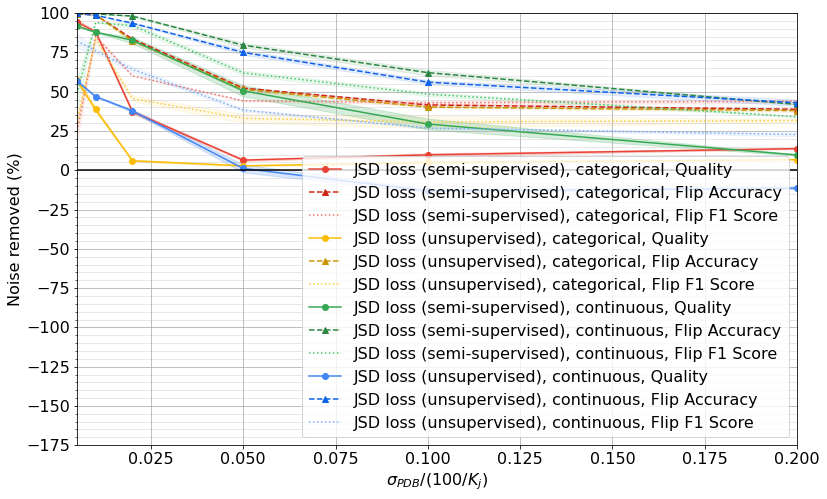

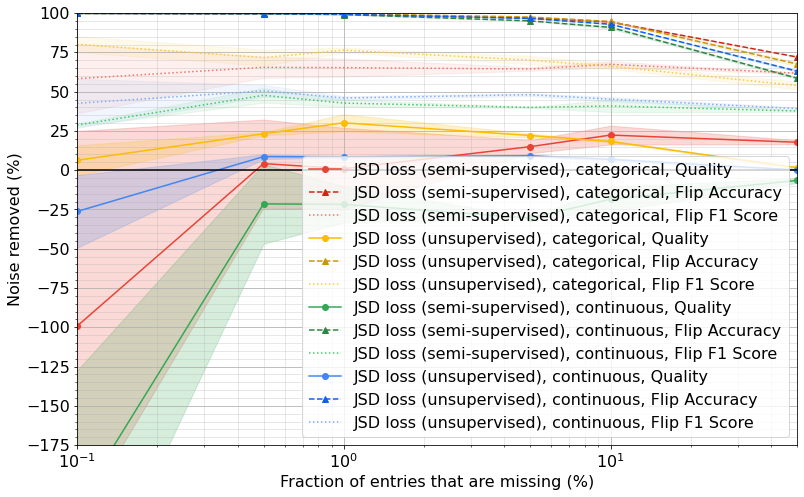

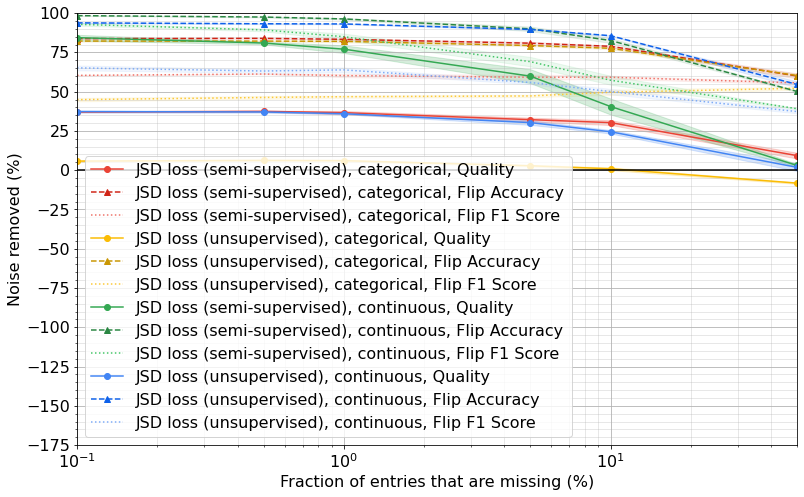

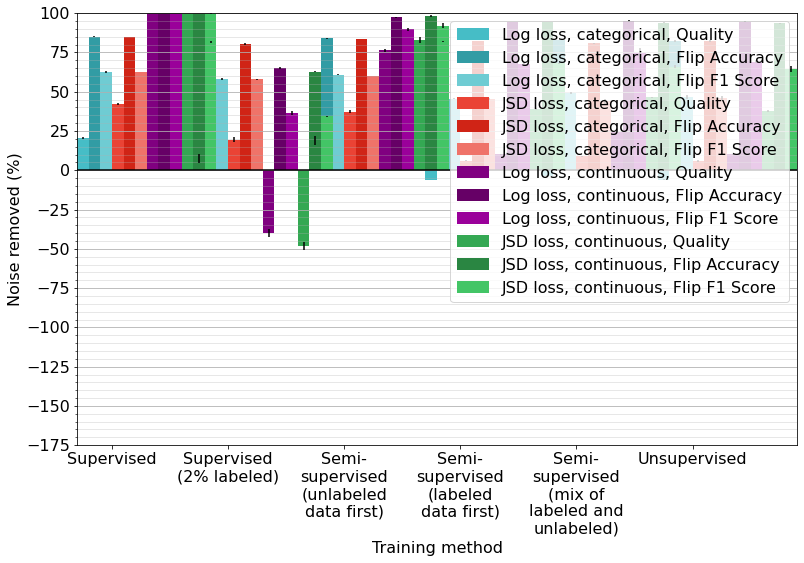

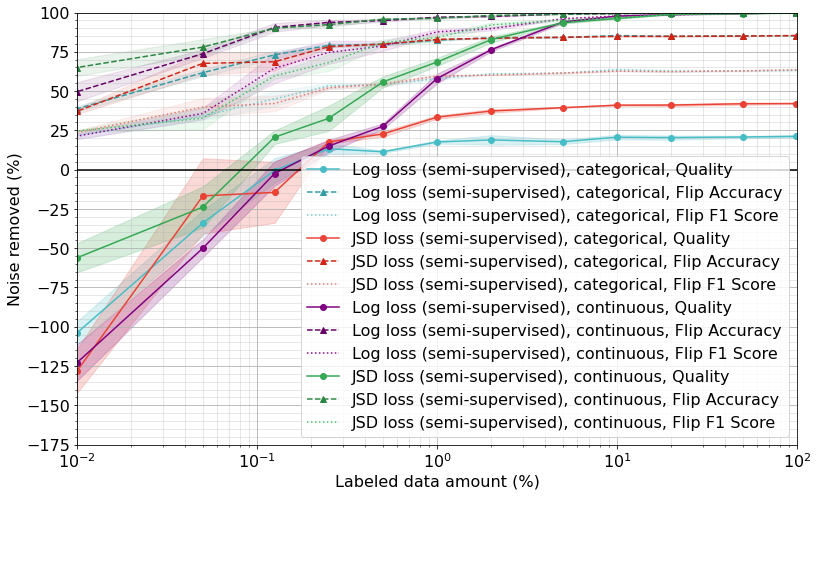

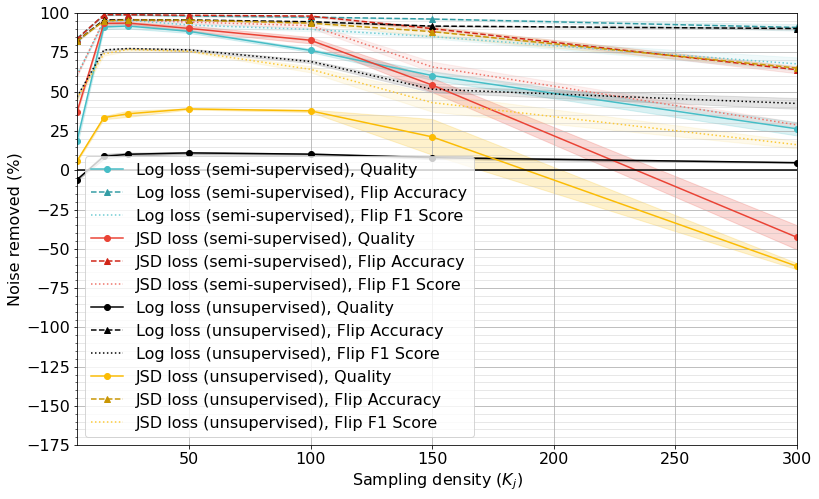

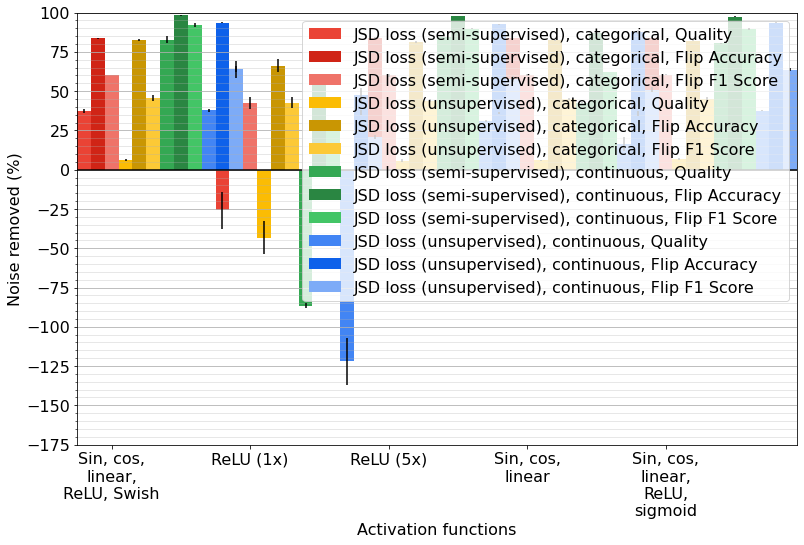

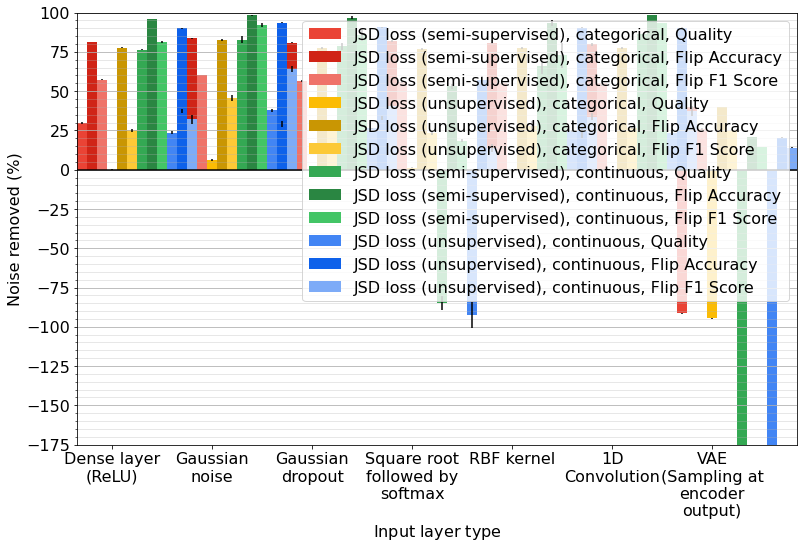

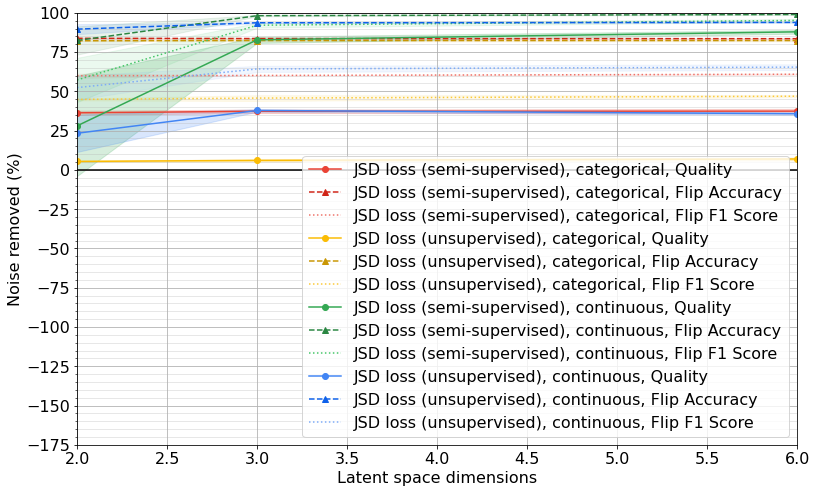

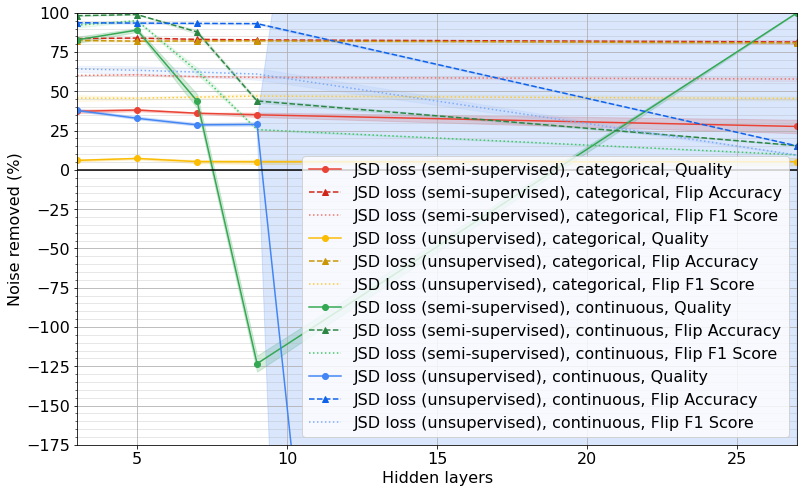

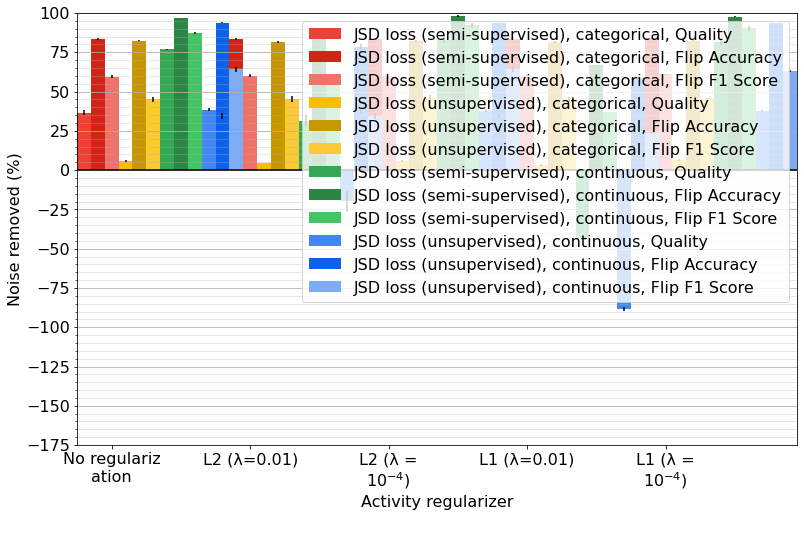

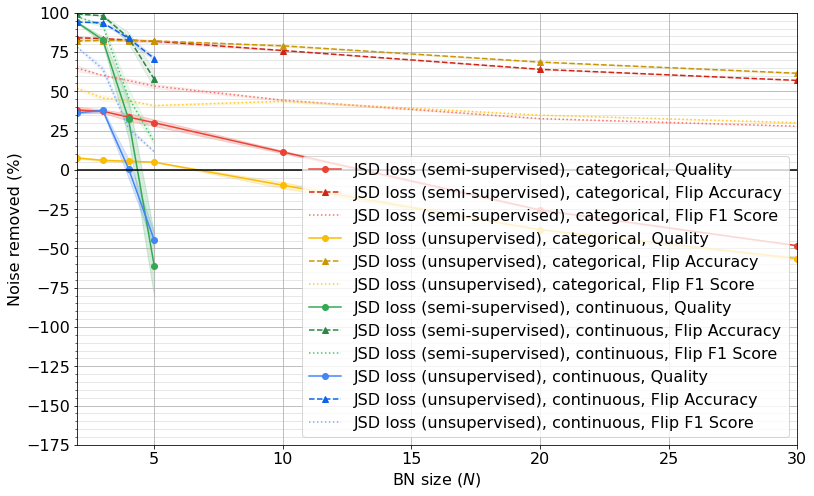

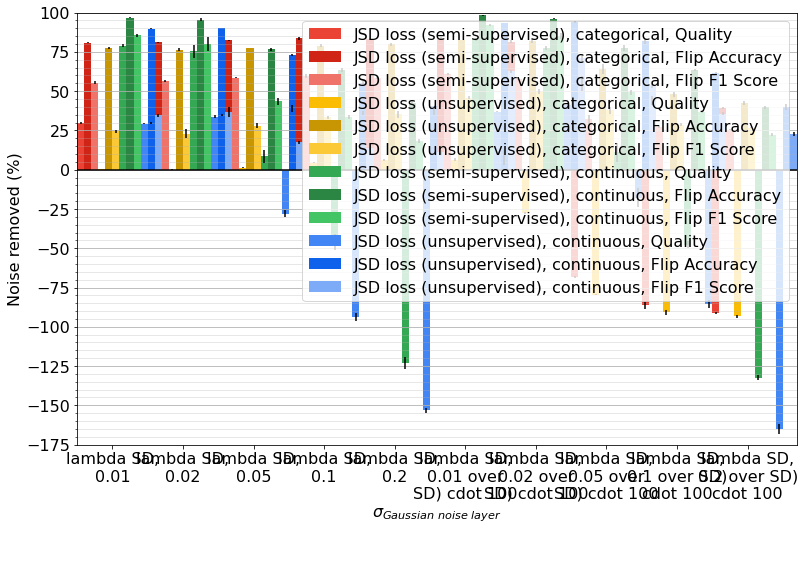

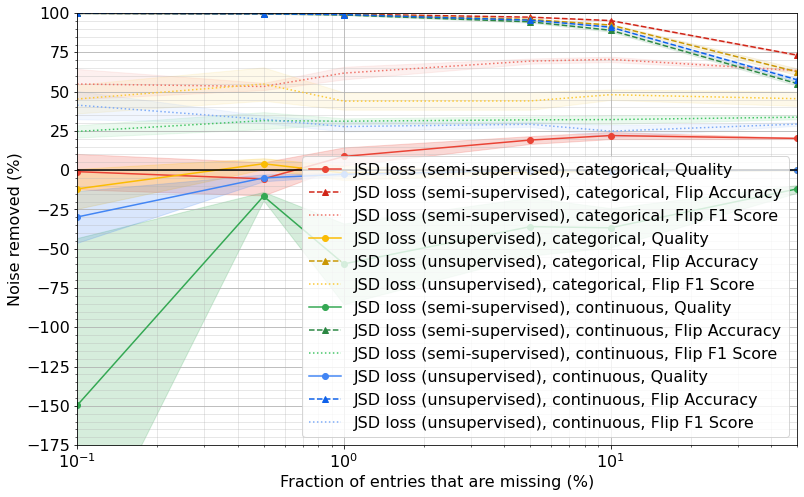

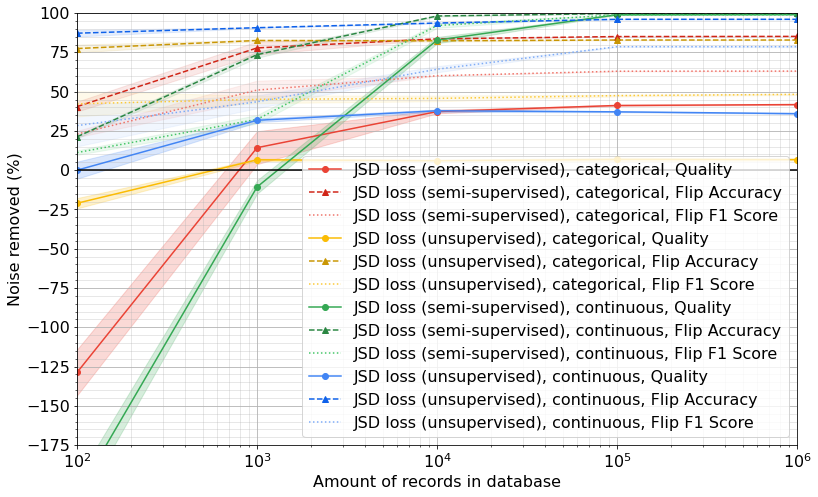

In [4]:
font = {
        # 'family' : 'serif',
        # 'serif':'test',
        # 'serif': 'cmr10',
        # 'serif': 'Latin Modern Roman',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=False)
for i in range(len(parameters)):
# for i in [0,1,2,3]:
    param = parameters[i]

    if param == "labeled_data_percentage" or param=="training_method" or param=="sampling_density":
        excluded_config_strings=[]
    else:
        excluded_config_strings=CCE_strings
    plot_vals(i,USE_PLOTLY=False,excluded_config_strings=excluded_config_strings)
    plt.savefig("figures/results_fig_"+ parameters[i] + ".svg", bbox_inches = 'tight',pad_inches = 0)



In [5]:
for i in range(len(parameters)):
    param = parameters[i]

    if param == "labeled_data_percentage" or param=="training_method" or param=="sampling_density":
        excluded_config_strings=[]
    else:
        excluded_config_strings=CCE_strings
    plot_vals(i,USE_PLOTLY=True,excluded_config_strings=excluded_config_strings)



UnboundLocalError: local variable 'means' referenced before assignment

In [ ]:
# a=[len(experiment_config_results[x['mapping']]) for i,x in enumerate(experiments)]
# unique, counts = np.unique(a, return_counts=True)
# dict(zip(unique, counts))


# [str(i) + ": " + x['full_string'] + " --- " +  str(len(experiment_config_results[x['mapping']])) for i,x in enumerate(experiments)]

[str(i) + ": " +  str(len(experiment_config_JSD_after[x['mapping']])) for i,x in enumerate(experiments)]

